# This codes downloads data from NASA's EarthData Server

Refer to this website for setting up permissions to access the NASA GES DISC server directly from the python script - https://disc.gsfc.nasa.gov/data-access#python


In [1]:
import numpy as np

import requests

import netCDF4
from netCDF4 import Dataset
import xarray

import os 

#from mpl_toolkits.basemap import Basemap

import glob

import pandas as pd

import os


1. Dynamically generate URLs to access daily data for the required durations

2. Combine the individual netCDF4 (.nc4) files into a single .nc4 data with the required fields

3. Plot the data

In [ ]:
# Specify year, month and date range to download the data (to access daily data)
year = '2011'
month = '%0.2d' % 9
dateRange = np.arange(1,32)

# Empty array to record saved file
filesList = []

# Loop through the days to downlaod the data
for i in dateRange:
    # Reformat the days to have a leading 0 if between 1-9
    day = '%0.2d' % i
   
    # Generate the download URL based on year, month and day
    URL = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGDF.06/'+str(year)+'/'+str(month)+'/3B-DAY.MS.MRG.3IMERG.'+str(year) + str(month) + str(day) +'-S000000-E235959.V06.nc4'
    
    # filename for the downloaded file (with file extension)
    filename = 'GPM_IMERG_'+str(URL[-32:-24])+'.nc4'
    filesList.append(filename)
    #print(filename)
    result = requests.get(URL, allow_redirects = True)
    try:
        result.raise_for_status()
        f = open(filename,'wb')
        f.write(result.content)
        f.close()
        print('File saved to '+filename)
    except:
        if (result.status_code == 200):
            print('File saved to '+filename)
        else:
            print('requests.get() returned an error code '+str(result.status_code))


In [ ]:
# Accessing the saved netCDF files
ff = filesList[0]
tempFileName = ff.rstrip('\n')
data = Dataset(r"{}".format(tempFileName))

# Print the names of the variables
print(data.variables.keys())

lon = data.variables['lon']
print(lon)
lonData = data.variables['lon'][:]
print(lonData)

timeData = data.variables['time'][:]
print(timeData)

In [ ]:
# Extracting rainfall time series for a soecific location from the saved netCDF files

# Saving the days from saved files into a list
fileDates = []

for file in glob.glob('*.nc4'):
    date = file[-12:-4]
    fileDates.append(date)
    
fileDates = sorted(fileDates)

### Creating a pandas data frame to cover the range of data
# Specifying the range of dates for the saved files
startDate = str(fileDates[0][0:4]) + '-' + str(fileDates[0][4:6]) + '-' + str(fileDates[0][6:8])
endDate = str(fileDates[-1][0:4]) + '-' + str(fileDates[-1][4:6]) + '-' + str(fileDates[-1][6:8])

dateRange = pd.date_range(start = startDate,
                         end = endDate,
                         freq = 'D')
df = pd.DataFrame(columns = ['HQPrecipitation (mm)', 'precipitationCal (mm)'], index = dateRange)

## Define the coordinates of the required lat, lon coordinates 
# lat, lon for Bangkok (https://www.latlong.net/place/bangkok-central-thailand-thailand-778.html)
latBangkok = 13.736717
lonBangkok = 100.523186

# Reading the data
for fdate in fileDates:
    data = Dataset('GPM_IMERG_'+str(fdate)+'.nc4','r')
    
    # Extracting lat and lon data
    lat = data.variables['lat'][:]
    lon = data.variables['lon'][:]
    
    # Squared difference with the specified coordinates
    sqDifLat = (lat - latBangkok)**2
    sqDifLon = (lon - lonBangkok)**2
    
    # Identify index of correct row for specified coordinates
    indexLat = sqDifLat.argmin()
    indexLon = sqDifLon.argmin()
    
    # Accessing precipitation data (HQprecipitation)
    HQprecipitation = data.variables['HQprecipitation']
    precipitationCal = data.variables['precipitationCal']
    
    # Updateing data frame with values from the netCDF filess
    df.loc[dateRange[fileDates.index(fdate)]]['HQPrecipitation (mm)'] = HQprecipitation[0, indexLon, indexLat]
    df.loc[dateRange[fileDates.index(fdate)]]['precipitationCal (mm)'] = precipitationCal[0, indexLon, indexLat]
    #print(dateRange[fileDates.index(fdate)])
    
print(data.variables['HQprecipitation'])
print(indexLat,indexLon)    
print(df)
#print(dateRange)
        
# Saving dataframe to csv
df.to_csv('GPMIMERGPrecipitation.csv')
    
    


In [ ]:
# Testing the data files

data = Dataset('combined/GPM_IMERG_CombinedRainfallRateCal.nc4','r')
dataSep = Dataset('combined/GPM_IMERG_SepOct_CombinedRainfallRateCal.nc4','r')
# print(data.variables['PrecipitationRate'])
# print(data.variables['PrecipitationRate'][0,:,:])
print(data.variables['PrecipitationRate'][0,900,1800])
print(dataSep.variables['PrecipitationRate'][30,900,1800])


In [ ]:
#####################################################################
## Combining all netcdf files in the directory to one file ########
## Filename: "GPM_IMERG_YYYYMMDD.nc4" #############################
###################################################################

## https://pyhogs.github.io/intro_netcdf4.html
# Importing data from one netCDF file and creating another netCDF file

# Using one of the saved netCDF files to create the dimensions for the new netCDF file
data = Dataset('GPM_IMERG_20111001.nc4','r')
nlon = len(data.variables['lon'][:])
nlat = len(data.variables['lat'][:])
lonValues = data.variables['lon'][:] 
latValues = data.variables['lat'][:]

# Saving the days from saved files into a list
fileDates = []

for file in glob.glob('*.nc4'):
    date = file[-12:-4]
    fileDates.append(date)
    
fileDates = sorted(fileDates)

ntime = len(fileDates)

# Name of the file to save the data to
#fileName = "GPM_IMERG_SepOct_CombinedPrecipitationCal.nc4"
fileName = 'GPM_IMERG_SepOct_CombinedRainfallRateCal.nc4'
#'GPM_IMERG_CombinedRainfallRate.nc4' 
# Specify the path to save the new netCDF file
# Using a subfolder since the immediately previous part of this code reads all netCDF files in this directory
filePath = 'C:/Users/wee055/Documents/SwiftProjects/Thailand_2020/Inputs/SpatioTemporalRainfall/GPM_IMERG Rainfall/combined/' + fileName

# Checking if the specified path exits and re-create a file if it exists
if os.path.exists(filePath):
    os.remove(filePath)
    # Create new netCDF4 file
    newFile = Dataset(filePath, 'w', format='NETCDF4')
    print('Removed and created new netCDF file: '+ filePath)
    
else:
    # Create new netCDF4 file
    newFile = Dataset(filePath, 'w', format='NETCDF4')
    print('Created new netCDF file: '+ filePath)

# Specify dimensions for time, lon and lat 
newFile.createDimension('time',ntime)
newFile.createDimension('lat',nlat)
newFile.createDimension('lon',nlon)

# Building the required variables
time = newFile.createVariable('time','f8','time')
longitude = newFile.createVariable('lon','f4','lon')
latitude = newFile.createVariable('lat','f4','lat')
#HQprecipitation = newFile.createVariable('HQprecipitation','f4',('time','lon','lat'))
#PrecipitationCal = newFile.createVariable('PrecipitationCal','f4',('time','lon','lat'))
PrecipitationRate = newFile.createVariable('PrecipitationRate','f4',('time','lat','lon'))

### Adding attributes to variable instances
time.units = data.variables['time'].units
time.calendar = data.variables['time'].calendar
longitude.units = data.variables['lon'].units
latitude.units = data.variables['lat'].units
#HQprecipitation.units = data.variables['HQprecipitation'].units
#PrecipitationCal.units = data.variables['precipitationCal'].units
PrecipitationRate.units = 'mm/hr'

# Filling new netCDF file with lon and lat values
longitude[:] = lonValues
latitude[:] = latValues

# Loop to add time and precipitation values
timeCount = 0
timeArray = []
for date in fileDates:
    dataFile = Dataset('GPM_IMERG_'+str(date)+'.nc4','r')
    timeArray.append(dataFile.variables['time'][:])
    
   # HQprecipitation[timeCount,:,:] = dataFile.variables['HQprecipitation'][0,:,:]
    # mm/per day > mm/hr
    scaleFactor = 1.0/24.0
    PrecipitationRate[timeCount,:,:] = np.transpose(dataFile.variables['precipitationCal'][0,:,:]*scaleFactor)
    #PrecipitationCal[timeCount,:,:] = dataFile.variables['precipitationCal'][0,:,:]
    print(date)
    # Transpose grid to be read on csol
#     for ii in range(nlon):
#             PrecipitationRate[timeCount,:,ii] = dataFile.variables['precipitationCal'][0,ii,:]*scaleFactor
       
          
    timeCount += 1
    
# Saving the time values
time[:] = timeArray  

# Close the new netCDF file
newFile.close()

# print(data.variables.keys())
# print(data.variables['HQprecipitation'][0,3599,1])
#print(data.variables['HQprecipitation'].units)
print('Finished Saving :)')
#print(newFile.variables.keys())


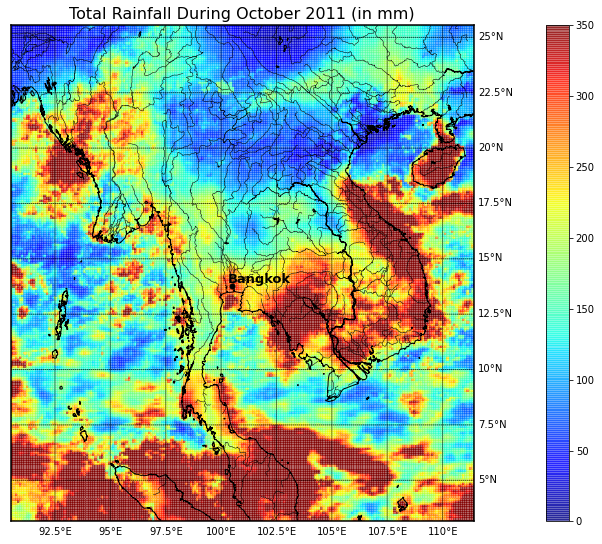

In [12]:
##########################################################################
## Plotting the cumulative rainfall using the total rainfall .nc4 file ###
## Not using the rainfall rate file ######################################
##########################################################################
import matplotlib.pyplot as plt
import os
os.environ["PROJ_LIB"] = "C:/ProgramData/Anaconda3/Library/share"
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
from numpy import meshgrid

###
variableName = 'PrecipitationCal'
file = Dataset('combined/GPM_IMERG_CombinedPrecipitationCal.nc4','r')
#variableName = 'HQprecipitation'
#variableName = 'PrecipitationRate'
#file = Dataset('combined/GPM_IMERG_CombinedRainfallRateCal.nc4','r')
lats = file.variables['lat'][:]
lons = file.variables['lon'][:]
time = file.variables['time'][:]
prec = file.variables[variableName][:]

dx = (lons[-1]-lons[0])/float(len(lons)-1)
dy = (lats[-1] - lats[0]) / float(len(lats) - 1)

# Creating the initial array to specify the size of the array
data = prec[0]

# Looping through each time step 
#for t in range(len(time)):
#    data[:,:] += prec[t,:,:]
    
# Correcting the array by reducing the double counted time value
#data[:,:] += data[:,:] - prec[0]
#data = np.add(prec[t] for t in time)

# Average of the 31-day data
dataAverage = data/len(time)

#data = ma.array(data, mask=np.isnan(data))
data = np.ma.masked_where(data<0.01, data)

lons_p1 = list(lons) + [lons[-1] + dx, ]
lons_m1 = [lons[0] - dx] + list(lons)
lons_corn = [(a + b) / 2.0 for a, b in zip(lons_p1, lons_m1) ]

lats_p1 = list(lats) + [lats[-1] + dy, ]
lats_m1 = [lats[0] - dy] + list(lats)
lats_corn = [(a + b) / 2.0 for a, b in zip(lats_p1, lats_m1) ]

lat2d, lon2d = np.meshgrid(lats_corn, lons_corn)

#mp = Basemap(projection = 'merc',llcrnrlon = 99.5,llcrnrlat = 13.1401,
#             urcrnrlon = 101.4,
#             urcrnrlat = 15.55)

mp = Basemap( llcrnrlon = 90.5,llcrnrlat = 3.1401,
             urcrnrlon = 111.4,
             urcrnrlat = 25.55, resolution = 'h')
# mp = Basemap( llcrnrlon = 96,llcrnrlat = 10,
#              urcrnrlon = 105,
#              urcrnrlat = 20, resolution = 'h')

meridians = np.arange(-180, 180, 2.5)
parallels = np.arange(-90, 90, 2.5)

x,y = mp(lon2d, lat2d)

# x = np.ma.masked_where(x<1, x)
# y = np.ma.masked_where(y<1, y)

plt.figure(figsize=(10, 10))

mp.pcolormesh(x,y,sum(prec[:]), cmap = 'jet', vmin = 0, vmax = 350, alpha = 0.6)

# plot Bangkok as a point on the map
lonBangkok = 100.5018
latBangkok = 13.7563
xb,yb = mp(lonBangkok,latBangkok)
mp.plot(xb,yb,'k.',markersize=10)
plt.text(xb-0.2,yb+0.15,'Bangkok',fontsize =13, fontweight = 'demi')

mp.colorbar(pad=1.0)
mp.drawcountries()
mp.drawcoastlines()
mp.drawrivers()
mp.drawmapboundary(linewidth=1.5)
mp.drawmeridians(meridians,labels=[True,False,False,True])
mp.drawparallels(parallels,labels=[False,True,True,False])
#mp.drawmeridians(np.arange(-7.0,2.0,1.0),labels=[1,0,0,0]) #longitudes
#mp.drawparallels(np.arange(51.0,58.0,1.0),labels=[0,0,0,1]) #latitudes

plt.title('Total Rainfall During October 2011 (in mm)', fontsize = 16)
plt.savefig('OctoberTotal'+variableName+'.jpg', dpi = 300)

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ["PROJ_LIB"] = "C:/ProgramData/Anaconda3/Library/share"
from mpl_toolkits.basemap import Basemap
import numpy.ma as ma
from numpy import meshgrid

file = Dataset('combined/GPM_IMERG_Combined.nc4','r')

lats = file.variables['lat'][:]
lons = file.variables['lon'][:]
time = file.variables['time'][:]
prec = file.variables['PrecipitationRate'][:]

dx = (lons[-1]-lons[0])/float(len(lons)-1)
dy = (lats[-1] - lats[0]) / float(len(lats) - 1)

# Creating the initial array to specify the size of the array
data = prec[0]

# Looping through each time step 
for t in range(len(time)):
    data[:,:] += prec[t,:,:]
    
# Correcting the array by reducing the double counted time value
data[:,:] += data[:,:] - prec[0]

# Average of the 31-day data
dataAverage = data/len(time)

#data = ma.array(data, mask=np.isnan(data))
data = np.ma.masked_where(data<0.01, data)

lons_p1 = list(lons) + [lons[-1] + dx, ]
lons_m1 = [lons[0] - dx] + list(lons)
lons_corn = [(a + b) / 2.0 for a, b in zip(lons_p1, lons_m1) ]

lats_p1 = list(lats) + [lats[-1] + dy, ]
lats_m1 = [lats[0] - dy] + list(lats)
lats_corn = [(a + b) / 2.0 for a, b in zip(lats_p1, lats_m1) ]

#lat2d, lon2d = np.meshgrid(lats_corn, lons_corn)
lat2d, lon2d = np.meshgrid(lats, lons)

#mp = Basemap(projection = 'merc',llcrnrlon = 99.5,llcrnrlat = 13.1401,
#             urcrnrlon = 101.4,
#             urcrnrlat = 15.55)
mp = Basemap(llcrnrlon = 90.5,llcrnrlat = 3.1401,
             urcrnrlon = 111.4,
             urcrnrlat = 25.55)
x,y = mp(lon2d, lat2d)
#x = np.ma.masked_where(x<1, x)
#y = np.ma.masked_where(y<1, y)

plt.figure(figsize=(10, 10))

mp.pcolormesh(lat2d,lon2d, data, cmap = 'jet', vmin = 0, vmax = 200)
#mp.contourf(lons,lats,data)

mp.colorbar()
mp.drawcountries()
mp.drawcoastlines()

